In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import torch.nn as nn
import torch.utils.data as data_utils
import torchvision
from sklearn.metrics import f1_score

### Dataset download and data processing

In [2]:
dataset = torchvision.datasets.MNIST('./data', train=True, download=True)

def create_subset(data, start, end):
    transform = torchvision.transforms.ToTensor()
    img_subset = []
    label_subset = []
    for i in range(start, end, 1):
        img, class_label =  data[i]
        img = transform(img)/255

        label = [0. for i in range(10)]
        label[class_label] = 1.

        img_subset.append(img)
        label_subset.append(label)

    return torch.cat(img_subset), torch.tensor(label_subset)

X_train, y_train = create_subset(dataset, 0, 45000)
X_validation, y_validation = create_subset(dataset, 45000, 50000)
X_test, y_test = create_subset(dataset, 50000, len(dataset))


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



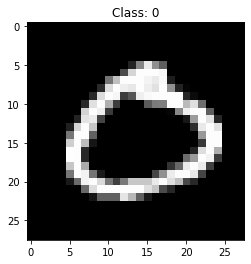

In [3]:
sample_img, img_class = dataset[np.random.randint(len(dataset))]

plt.imshow(sample_img, cmap='gray', vmin=0, vmax=255)
plt.title(f"Class: {img_class}")
plt.show()

### Definition of the classification model

In [4]:
class MnistNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear1 = nn.Linear(28*28, 256)
        self.linear2 = nn.Linear(256, 64)
        self.linear3 = nn.Linear(64, 10)

        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, img_in):

        out = self.linear1(img_in.view(-1, 28*28))
        out = self.relu(out)
        out = self.linear2(out)
        out = self.relu(out)
        out = self.linear3(out)
        out = self.softmax(out)

        return out


### Dataloaders, optimizer and loss function

In [5]:
b_size = 64

train_dataset = data_utils.TensorDataset(X_train, y_train)
train_dataloader = data_utils.DataLoader(train_dataset, batch_size=b_size)

validation_dataset = data_utils.TensorDataset(X_validation, y_validation)
validation_dataloader = data_utils.DataLoader(validation_dataset, batch_size=b_size)

test_dataset =  data_utils.TensorDataset(X_test, y_test)
test_dataloader = data_utils.DataLoader(test_dataset, batch_size=b_size)

model = MnistNN()

lr = 1e-4
optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, alpha=0.9)

loss_fn = nn.CrossEntropyLoss()

In [38]:
EPOCH_NUM = 100

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)

def error(logits, labels):
    res = logits == labels
    res = np.argmax(logits, axis=1) == np.argmax(labels, axis=1)
    return torch.numel(res[res==True])/len(logits)

train_accuracy = []
train_loss = []
validation_accuracy = []
validation_loss = []
val_batches = len(validation_dataloader)
num_batches = len(train_dataloader)

for epoch in range(EPOCH_NUM):

    loss_history = []
    val_loss_history = []
    validation_iter = enumerate(validation_dataloader)
    val_idx = -1

    epoch_train_accuracy = []
    epoch_validation_accuracy = []

    for idx, (img, label) in enumerate(train_dataloader):
        
        img = img.to(device)
        labels = label.to(device)

        optimizer.zero_grad()

        logits = model(img)
        loss = loss_fn(logits, label)

        loss_history.append(loss.item())

        if(idx%9 == 0 and val_idx < len(validation_dataloader)-1):
            with torch.no_grad():
                epoch_train_accuracy.append(error(logits, labels))

                val_idx, (val_img, val_labels) = next(validation_iter)
                val_logits = model(val_img)
                val_loss_history.append(loss_fn(val_logits, val_labels).item())

                epoch_validation_accuracy.append(error(val_logits, val_labels))

        if(epoch%5 == 0 and idx == num_batches-1):
            avg_loss = sum(loss_history)/num_batches
            avg_val_loss = sum(val_loss_history)/val_batches
            train_loss.append(avg_loss)
            validation_loss.append(avg_val_loss)

            avg_train_error = sum(epoch_train_accuracy)/val_batches
            avg_val_error = sum(epoch_validation_accuracy)/val_batches
            train_accuracy.append(avg_train_error)
            validation_accuracy.append(avg_val_error)
            print(f"Epoch: {epoch+1} -- Average loss: {avg_loss} -- ")

        loss.backward()
        optimizer.step()


Epoch: 1 -- Average loss: 1.6038648193194107 -- 
Epoch: 6 -- Average loss: 1.5984449862417849 -- 
Epoch: 11 -- Average loss: 1.5935303015126423 -- 
Epoch: 16 -- Average loss: 1.5891417474909262 -- 
Epoch: 21 -- Average loss: 1.585243198004636 -- 
Epoch: 26 -- Average loss: 1.5817353337664495 -- 
Epoch: 31 -- Average loss: 1.5784974738278172 -- 
Epoch: 36 -- Average loss: 1.5754629238085314 -- 
Epoch: 41 -- Average loss: 1.572645768861879 -- 
Epoch: 46 -- Average loss: 1.5699870935217901 -- 
Epoch: 51 -- Average loss: 1.5674607394771143 -- 
Epoch: 56 -- Average loss: 1.56504981033504 -- 
Epoch: 61 -- Average loss: 1.562749539755962 -- 
Epoch: 66 -- Average loss: 1.5605835933238268 -- 
Epoch: 71 -- Average loss: 1.5585569309240037 -- 


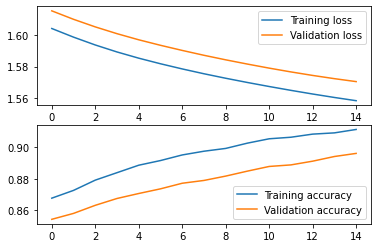

In [41]:
fig, (ax1, ax2) = plt.subplots(2)

ax1.plot(train_loss, label='Training loss')
ax1.plot(validation_loss, label='Validation loss')
ax1.legend()

ax2.plot(train_accuracy, label='Training accuracy')
ax2.plot(validation_accuracy, label='Validation accuracy')
ax2.legend()

plt.show()

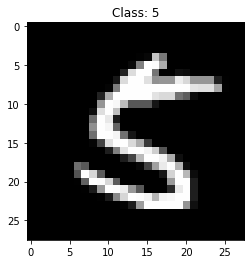

tensor(5)


In [60]:
sample_img, img_class = dataset[np.random.randint(len(dataset))]
#while(img_class != 5):
#    sample_img, img_class = dataset[np.random.randint(len(dataset))]

plt.imshow(sample_img, cmap='gray', vmin=0, vmax=255)
plt.title(f"Class: {img_class}")
plt.show()

with torch.no_grad():
    l = model(torchvision.transforms.ToTensor()(sample_img))
    l = np.argmax(l)
print(l)

### Bounding box calculation

In [9]:
def find_bbox(img):
    xs = ys = xe = ye = -1
    for i in range(28):
        for j in range(28):
            if img[i][j] != 0:
                if(ys == -1):
                    ys = i
                if(xs == -1 or j < xs):
                    xs = j
                if(i > ye):
                    ye = i
                if(j > xe):
                    xe = j
    
    return (xs-1, ys-1, xe+1, ye+1)

7 1 23 22


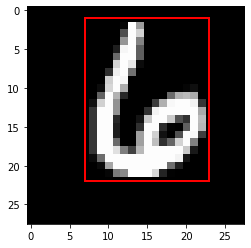

In [10]:
xs, ys, xe, ye = find_bbox(torchvision.transforms.PILToTensor()(sample_img)[0])
print(xs, ys, xe, ye)

fig, ax = plt.subplots()
ax.imshow(sample_img, cmap='gray', vmin=0, vmax=255)
rect = patches.Rectangle((xs, ys), xe-xs, ye-ys, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.show()